In [14]:
#imports
import cv2
import numpy as np
import sys

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import median,threshold_otsu
from skimage.morphology import binary_closing,binary_opening 
from skimage.feature import canny
from skimage.measure import find_contours
from sklearn.cluster import KMeans
import skimage.io as io
import numpy as np
from skimage import data, exposure, img_as_float

In [15]:
#detect shape of contours
def detect(c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
         
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
          
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "circle"
        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
        # return the name of the shape
        return shape

In [16]:
#show image
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [20]:
#read image
path ="BubbleSheetTests/test8.jpg"
img = cv2.imread(path)
dim=(700,700)
image =img.copy()

In [21]:
def GrayScaleImage(img):
    #convert image to gray image
    imgGray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    show_images([imgGray],["Gray Image"])
    return imgGray

In [22]:
def BluringImage(imgGray):
    # kernal size(3,3) & sigma = 1
    # may think again in img bluring
    imgBlur =cv2.GaussianBlur(imgGray,(3,3),1)
    show_images([imgBlur],["Image Bluring"])
    return imgBlur

In [23]:
def GraytoBinary(imgBlur):
    #BI-MODEL THRESHOLDING using two peaks 
    BinaryImage = cv2.adaptiveThreshold(imgBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY_INV,33,5)
    show_images([BinaryImage],["Binary Image"])
    return BinaryImage

In [25]:
def allContours(img ,BinaryImage):
    #get contours in image
    cnts ,hierarchy  = cv2.findContours(BinaryImage.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image= img.copy()
    # loop over the contour
    charsAndShapes =[]
    hierarchyShape= [] 
    
    for c in cnts:
 
        shape = detect(c)
 
        if shape!='rectangle' and shape !='square':
        #if shape in not rect or square => so assume chars and circle
            charsAndShapes.append(c)

        else:
             cv2.drawContours(image, [c], -1, (0, 255, 0), 1)

         # show the output image

    show_images([image],["Image"])
    return charsAndShapes

In [26]:
def charandCircles(img,BinaryImage,charsAndShapes):
    new_image= img.copy()
    circles=[]
    maskimage= np.zeros(BinaryImage.shape, dtype='uint8')
    #now i just have circles and chars
    for c in charsAndShapes:
        (x1, y1, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        # loop on contours if aspect ratio in accepted range so it circle
        if ar >= 0.75 and ar <= 1.4 :
            circles.append(c)
            # draw image with circle conoturs
            maskimage  [y1:y1+h, x1:x1+w] = BinaryImage[y1:y1+h, x1:x1+w]
            cv2.drawContours(new_image, [c], -1, (0, 255, 0), 1)
    show_images([new_image ,maskimage],["Image" ,"masked"]) 
    print(len(circles))
    return circles,maskimage

In [27]:
def ClosingCircles(maskimage,img):
    kernel = np.ones((2, 2), np.uint8)
    newmask2= cv2.morphologyEx(maskimage, cv2.MORPH_CLOSE, kernel,iterations=5)
    show_images([newmask2] ,["Image" ])
    cnts ,hierarchy  = cv2.findContours(newmask2.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    test_image= img.copy()

    print(len(cnts))
    for c in cnts:
        cv2.drawContours(test_image, [c], -1, (0, 255, 0), 2)
    show_images([newmask2 , test_image],["Image" ,"Test Image"])
    return cnts

In [28]:
def Circle(img,BinaryImage,circles):
    test_image= img.copy()
    mask = np.zeros(BinaryImage.shape, dtype='uint8')
    
    areas =[]
    reminder =[]
    questionCnts =[]
    (xmin,ymin),r =cv2.minEnclosingCircle(circles[0])
    for c in circles:
        x,y,w,h = cv2.boundingRect(c)
#         print("X"+ str(x)+" ,Y"+str(y))
        #store area of all contours
        areas.append(w*h)
    areas = np.float32(areas)       
    # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 1.0)
    # Set flags (Just to avoid line break in the code)
    flags = cv2.KMEANS_RANDOM_CENTERS
    # Apply KMeans to clutser areas into 2 clutsers one for rows ,another for oultiers
    compactness,labels,centers = cv2.kmeans(areas,2,None,criteria,10,flags)       
    A = areas[labels.ravel()==0]
    B = areas[labels.ravel()==1]
    
    for i in range (0 ,len(circles)):
        if len(A)> len(B):
            if labels[i]==0:
                questionCnts.append(circles[i])
        else:
            if labels[i]==1:
                questionCnts.append(circles[i])
    print(len(questionCnts))           
     #some of contours may be repeated so just take it onece
     #this funnction needs to improve   
    reminder.append(questionCnts[0])
    for c in   questionCnts: 
        (x,y),radius = cv2.minEnclosingCircle(c)
        center = (int(x),int(y))
        if ( abs(x- xmin))>30 :
                reminder.append(c)
                xmin =x
#             else:
#                 ymin =y


    print(len(reminder))
    for c in reminder:
            x,y,w,h = cv2.boundingRect(c)
            cv2.drawContours(test_image, [c], -1, (0, 255, 0), 2)
            mask[y:y+h, x:x+w] = BinaryImage[y:y+h, x:x+w]            

    print(len(questionCnts)) 
    show_images([mask , test_image],["Image" ,"Test Image"])   
    return mask,reminder

In [42]:
def rows(maskimage,img):
    kernel = np.ones((1, 3), np.uint8)
    #apply high dilation on rows
    newmask2=cv2.dilate(maskimage, kernel, iterations=20) 
    show_images([newmask2],["Image"])
    # get conotours of this high dilated image
    cnts ,hierarchy  = cv2.findContours(newmask2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(cnts)
    #ROWS ARE DONE

In [29]:
def columns(maskimage,img):
    newkernel = np.ones((3, 1), np.uint8)
    #apply high dilation on image
    newmask3=cv2.dilate(maskimage, newkernel, iterations=15) 
    # get contours of image
    cnts ,hierarchy  = cv2.findContours(newmask3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    show_images([newmask3],["Image"])
    return len(cnts)

In [30]:
def rows_sections(maskimage,img):
    kernel = np.ones((1, 3), np.uint8)
    #apply high dilation on rows
    newmask2=cv2.dilate(maskimage, kernel, iterations=100) 
    show_images([newmask2],["Image"])
    # get conotours of this high dilated image
    cnts ,hierarchy  = cv2.findContours(newmask2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(cnts)


In [31]:
def columns_sections(maskimage,img):
    kernel = np.ones((4, 1), np.uint8)
    #apply high dilation on rows
    newmask2=cv2.dilate(maskimage, kernel, iterations=20) 
    show_images([newmask2],["Image"])
    # get conotours of this high dilated image
    cnts ,hierarchy  = cv2.findContours(newmask2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(cnts)


In [32]:
def sort_contours(circles,reminder):
    questions =[]
    for c in circles:
        for r in reminder:
            (x, y, w, h) = cv2.boundingRect(c)
            (x1, y1, w1, h1) = cv2.boundingRect(r)
            if x==x1 and y==y1 and h==h1 and w==w1:
                questions.append(c)
                break
    return questions           

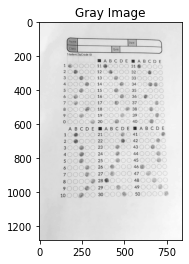

In [33]:
imgGray = GrayScaleImage(img)

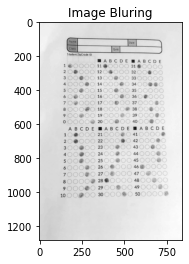

In [34]:
imgBlur = BluringImage(imgGray)

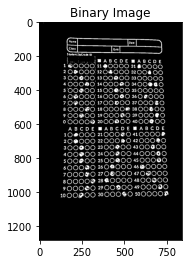

In [35]:
BinaryImage=GraytoBinary(imgBlur)

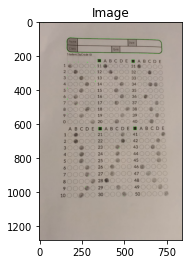

In [36]:
charsAndShapes=allContours(img,BinaryImage)

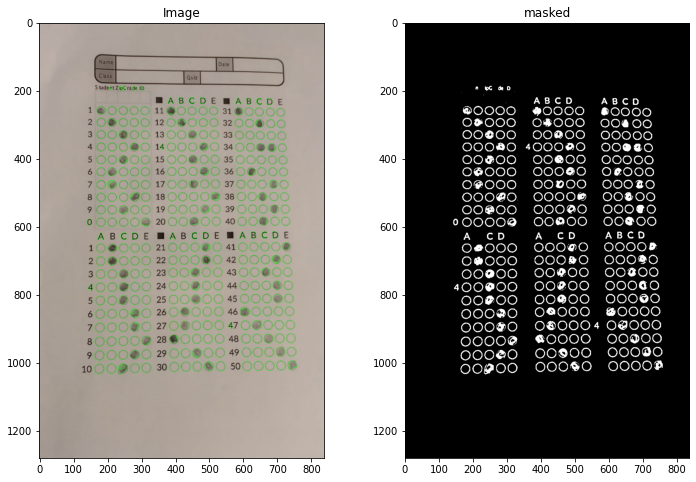

350


In [37]:
circles,maskimage=charandCircles(img,BinaryImage,charsAndShapes)

300
300
300


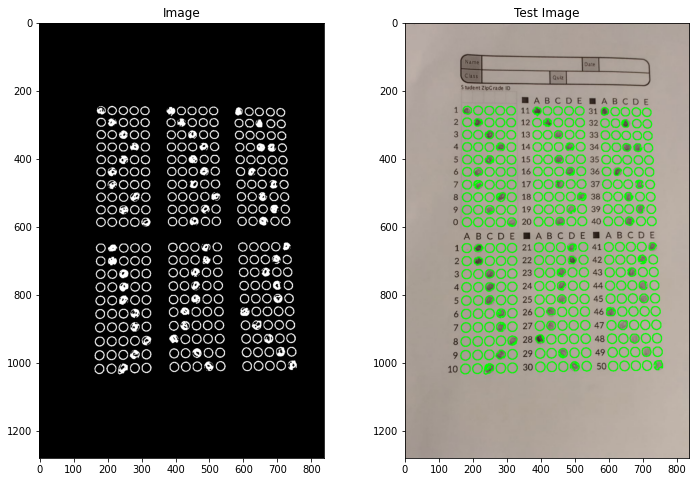

In [61]:
mask,reminder=Circle(img,maskimage,circles)

In [39]:
reminder=sort_contours(circles,reminder)

In [40]:
print(len(reminder))

300


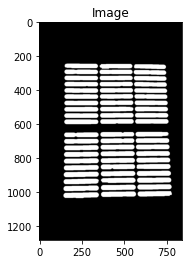

60


In [43]:
rows_number = rows(mask,img)
print(rows_number)

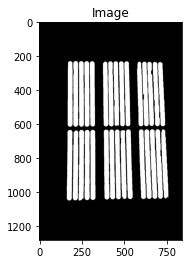

30


In [44]:
columns_number =columns(mask,img)
print(columns_number)

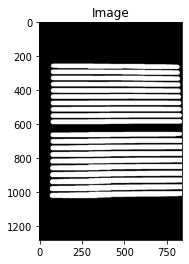

20


In [45]:
row_per_section =rows_sections(mask,img)
print(row_per_section)

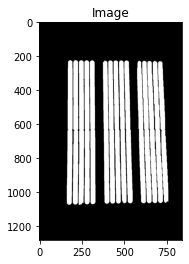

15


In [46]:
column_per_section= columns_sections(mask,img)
print(column_per_section)

In [47]:
def sort_columns(reminder,column_per_section):
    contours = []
    for i in range(0,len(reminder),column_per_section):
         cnts = reminder [i:i+column_per_section]
         arr =[]
         for c in cnts :
            (x, y, w, h) = cv2.boundingRect(c)
            arr.append(x)
         arr=np.sort(arr)
         print(arr)
         for e in arr:
                for cnt in cnts:
                     (x, y, w, h) = cv2.boundingRect(cnt)
                     if(x==e):
                        contours.append(cnt)
                        break
                
    return contours              
                

In [48]:
n_rows = rows_number/row_per_section
endpoint = rows_number/row_per_section
n_rows =column_per_section/n_rows

In [49]:
n_columns = columns_number/column_per_section
n_columns = row_per_section/n_columns

In [50]:
print(n_rows)
print(n_columns)

5.0
10.0


In [51]:
reminder=sort_columns(reminder,column_per_section)

[163 198 232 267 302 384 417 452 486 520 598 631 665 698 732]
[163 199 233 267 302 383 417 451 484 518 596 630 663 697 729]
[164 199 234 268 302 383 416 450 483 517 595 628 661 694 727]
[165 200 234 269 302 382 416 449 482 516 593 626 660 692 725]
[165 200 234 269 302 382 416 449 481 515 592 625 657 690 723]
[166 201 236 268 302 382 414 448 481 514 590 624 656 689 721]
[166 201 236 269 302 381 414 448 480 513 589 622 654 688 720]
[167 201 236 269 302 381 413 447 479 512 588 620 654 686 718]
[167 203 236 268 301 381 413 445 481 511 587 619 652 685 717]
[167 203 235 268 301 380 412 445 478 510 586 618 650 682 717]
[168 201 235 268 301 379 410 443 476 508 583 616 647 680 712]
[168 201 236 268 300 378 410 442 476 507 583 614 646 680 711]
[168 201 235 268 300 378 409 441 474 507 582 613 645 677 709]
[168 202 235 267 300 377 409 443 474 505 580 612 643 678 707]
[169 202 235 267 300 377 408 440 473 505 579 615 642 674 706]
[169 201 235 267 299 377 407 440 472 504 578 609 640 673 704]
[169 201

In [52]:
def  get_answers(n_rows, n_columns,reminder,BinaryImage,row_per_section,endpoint,rows_number):
    marked = np.zeros(BinaryImage.shape, dtype='uint8')
    notmarked = np.zeros(BinaryImage.shape, dtype='uint8')
    n_rows =int(n_rows)
    count=0
    total = int(n_rows*n_columns)
    intial = int(row_per_section)
    savepoint =endpoint
#     sortedCnts,boundingBoxes =sort_contours(reminder)
    sortedCnts = reminder
    arr =np.zeros(shape=(rows_number, n_rows))

    for i in range(0,len(sortedCnts),n_rows):
        cnts = sortedCnts [i:i+n_rows]
        j = 0
        for c in cnts:
            
            (x, y, w, h) = cv2.boundingRect(c)
#             print("X"+str(x)+" ,Y"+str(y))
            mask = np.zeros([h, w], dtype='uint8')
            mask[0:h, 0:w] = BinaryImage[y:y+h, x:x+w] 
            imgHist = exposure.histogram(mask, nbins=256)
             
            if(imgHist[0][0]<imgHist[0][255]):
                count+=1
                arr[int(intial)-1][j]=1
                marked [y:y+h, x:x+w]=BinaryImage[y:y+h, x:x+w]
            else :
               
                notmarked[y:y+h, x:x+w]=BinaryImage[y:y+h, x:x+w]
            j =j +1        
#        print(count)     
#         show_images([marked,notmarked],["Marked","not marked"])
        intial+= row_per_section
        endpoint -=1
        if endpoint ==0:
            endpoint=savepoint
            intial=intial-(endpoint) *row_per_section-1
   
    show_images([marked,notmarked],["Marked","not marked"]) 
    print(count)
    return arr
            

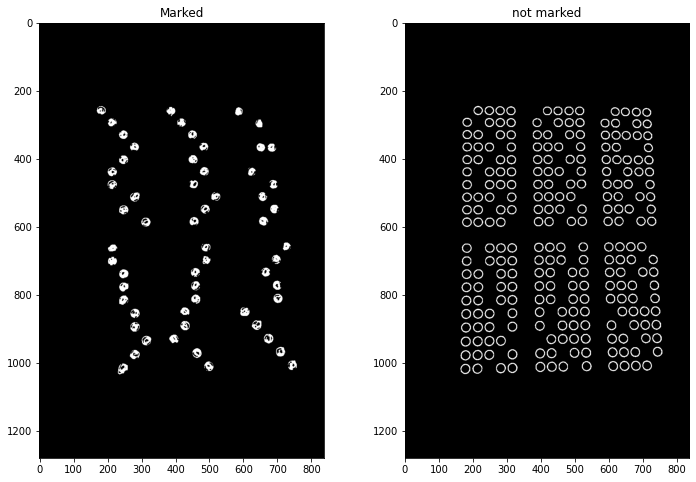

59


In [53]:
arr=get_answers(n_rows,n_columns,reminder,BinaryImage,row_per_section,endpoint,rows_number)

In [54]:
print(arr)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0.

In [55]:
def speratequestions(arr,n_columns):
    codes =[]
    n_columns =int(n_columns)
    questions =[]
    for i in range(0,n_columns):
        codes.append(arr[i])
    for i in range(n_columns,len(arr)):
        questions.append(arr[i])
    return codes,questions    

In [56]:
codes,questions=speratequestions(arr,n_columns)

In [57]:
print(codes)

[array([1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1.])]


In [58]:
print(questions)

[array([0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0.]), array([0., 0.

In [63]:
def BubbleSheet(img):
    imgGray = GrayScaleImage(img)
    imgBlur = BluringImage(imgGray)
    BinaryImage=GraytoBinary(imgBlur)
    charsAndShapes=allContours(img,BinaryImage)
    circles,maskimage=charandCircles(img,BinaryImage,charsAndShapes)
    mask,reminder=Circle(img,maskimage,circles)
    reminder=sort_contours(circles,reminder)
    print(len(reminder))
    rows_number = rows(mask,img)
    print(rows_number)
    columns_number =columns(mask,img)
    print(columns_number)
    row_per_section =rows_sections(mask,img)
    print(row_per_section)
    column_per_section= columns_sections(mask,img)
    print(column_per_section)
    n_rows = rows_number/row_per_section
    endpoint = rows_number/row_per_section
    n_rows =column_per_section/n_rows
    n_columns = columns_number/column_per_section
    n_columns = row_per_section/n_columns
    print(n_rows)
    print(n_columns)
    reminder=sort_columns(reminder,column_per_section)
    arr=get_answers(n_rows,n_columns,reminder,BinaryImage,row_per_section,endpoint,rows_number)
    codes,questions=speratequestions(arr,n_columns)
    print(codes)
    print(questions)
    
    
    
    
    
    

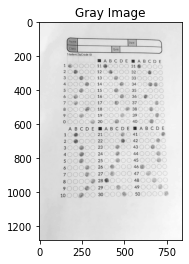

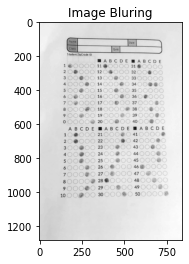

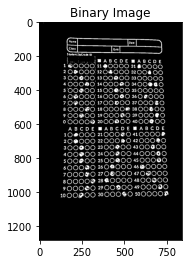

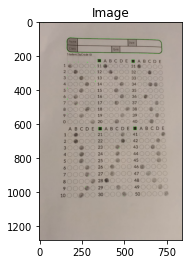

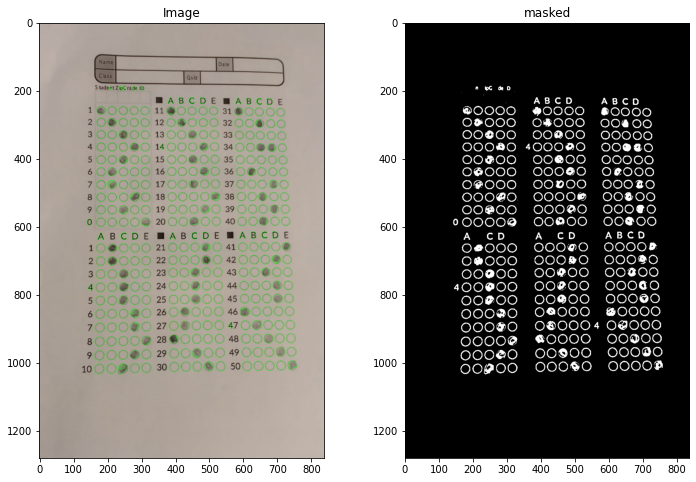

350
300
300
300


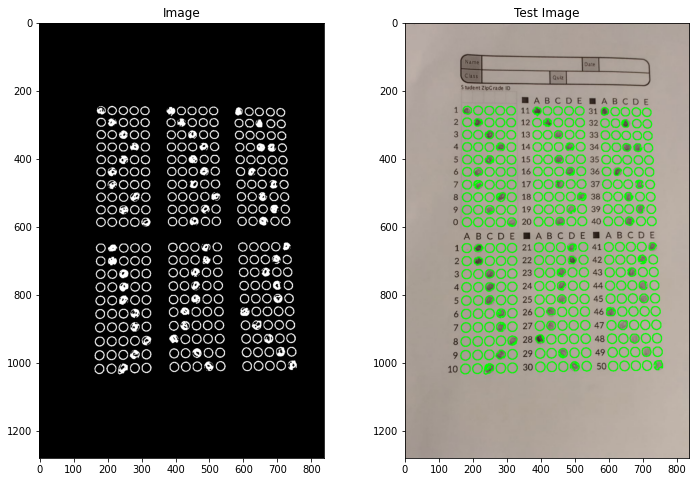

300


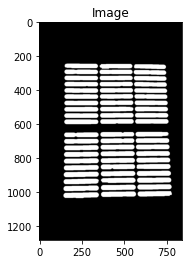

60


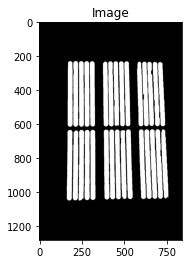

30


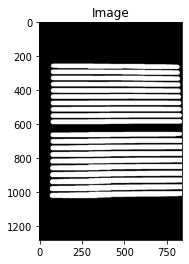

20


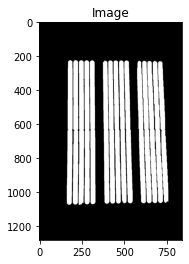

15
5.0
10.0
[163 198 232 267 302 384 417 452 486 520 598 631 665 698 732]
[163 199 233 267 302 383 417 451 484 518 596 630 663 697 729]
[164 199 234 268 302 383 416 450 483 517 595 628 661 694 727]
[165 200 234 269 302 382 416 449 482 516 593 626 660 692 725]
[165 200 234 269 302 382 416 449 481 515 592 625 657 690 723]
[166 201 236 268 302 382 414 448 481 514 590 624 656 689 721]
[166 201 236 269 302 381 414 448 480 513 589 622 654 688 720]
[167 201 236 269 302 381 413 447 479 512 588 620 654 686 718]
[167 203 236 268 301 381 413 445 481 511 587 619 652 685 717]
[167 203 235 268 301 380 412 445 478 510 586 618 650 682 717]
[168 201 235 268 301 379 410 443 476 508 583 616 647 680 712]
[168 201 236 268 300 378 410 442 476 507 583 614 646 680 711]
[168 201 235 268 300 378 409 441 474 507 582 613 645 677 709]
[168 202 235 267 300 377 409 443 474 505 580 612 643 678 707]
[169 202 235 267 300 377 408 440 473 505 579 615 642 674 706]
[169 201 235 267 299 377 407 440 472 504 578 609 640 673 7

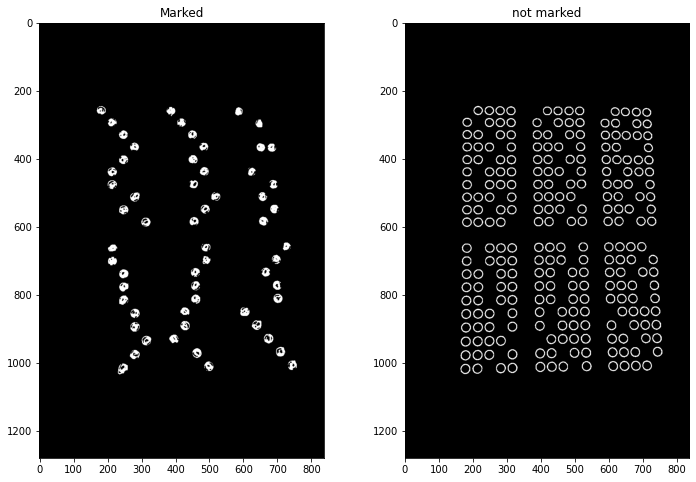

59
[array([1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1.])]
[array([0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0.

In [64]:
BubbleSheet(img)